<figure style="text-align: center;">
  <img src="_static/intro/title_page.png" style="display: block; margin: 0 auto; width: 100%;">
</figure>

### Machine Learning Modeling Tuning

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Machine Learning in Python: a Hands-on Guide with Code". 

```{admonition} Cite this e-Book as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *Applied Machine Learning in Python: A Hands-on Guide with Code* [e-book]. Zenodo. doi:10.5281/zenodo.15169138 [![DOI](https://zenodo.org/badge/863274676.svg)](https://doi.org/10.5281/zenodo.15169138) 
```

The workflows in this book and more are available here:

```{admonition} Cite the MachineLearningDemos GitHub Repository as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *MachineLearningDemos: Python Machine Learning Demonstration Workflows Repository* (0.0.3) [Software]. Zenodo. DOI: 10.5281/zenodo.13835312. GitHub repository: https://github.com/GeostatsGuy/MachineLearningDemos [![DOI](https://zenodo.org/badge/862519860.svg)](https://zenodo.org/doi/10.5281/zenodo.13835312)
```

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

TBD

#### Danger of Overfit

It follows that a sufficiently flexible, complicated trend model can perfectly fit the data. For example, a trend based on spatial interpolation would exactly honor the data at the data locations.

What would be the issue with that?

\begin{equation}
\sigma^2_{Y} \to 0
\end{equation}

\begin{equation}
Prop_{Known} = \frac{\sigma^2_{m}}{\sigma^2_{m}} = 100\%, \quad
Prop_{Unknown} = \frac{0}{\sigma^2_{m}} = 0\%
\end{equation} 

The result is a model that assumes that all variance is described by the deterministic trend; therefore is variance is partitioned to the known bin! This is a model without uncertainty. 

There's another aspect, the model that is very flexible will have more parameters to fit with the same number of data; therefore, the uncertainty in the fit of the model will increase. The model variance increases, in other words the model is more sensitive to the actually data available and is likely to be quite inaccurate away from the data.  

We can observe the impact of overfit with a very simple 1D problem.

#### Objective 

In the PGE 383: Stochastic Subsurface Modeling class I want to provide hands-on experience with building subsurface modeling workflows. Python provides an excellent vehicle to accomplish this. I have coded a package called GeostatsPy with GSLIB: Geostatistical Library (Deutsch and Journel, 1998) functionality that provides basic building blocks for building subsurface modeling workflows. 

The objective is to remove the hurdles of subsurface modeling workflow construction by providing building blocks and sufficient examples. This is not a coding class per se, but we need the ability to 'script' workflows working with numerical methods.    

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

You will need to copy the data file to your working directory.  They are available here:

* Tabular data - sample_data_biased.csv at https://git.io/fh0CW

There are exampled below with these functions. You can go here to see a list of the available functions, https://git.io/fh4eX, other example workflows and source code. 

In [6]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        

We will also need some standard packages. These should have been installed with Anaconda 3.

In [8]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import seaborn as sns                     # model confidence intervals

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [12]:
os.chdir("c:/PGE383")             # set the working directory

#### Simple Dataset

Let's make a simple dataset, permeability in 1D over the x coordinate, input in ndarrays and then combined into a Pandas DataFrame. We will also make sure that what we made are in fact ndarrays and a DataFrame.  

In [15]:
z = np.array([10,90,100,130,190,210,250,290])
perm = np.array([600,320,1200,750,340,1120,1690,1530])
print('z and perm are ' +str(type(z)) + ',' + str(type(perm)))
df = pd.DataFrame({'z':z,'perm':perm})
print('df is type ' + str(type(df)))
df.head()

z and perm are <class 'numpy.ndarray'>,<class 'numpy.ndarray'>
df is type <class 'pandas.core.frame.DataFrame'>


,z,perm
0,10,600
1,90,320
2,100,1200
3,130,750
4,190,340


Ok, we have a dataset ready to go, let's plot the data and see what we are dealing with.

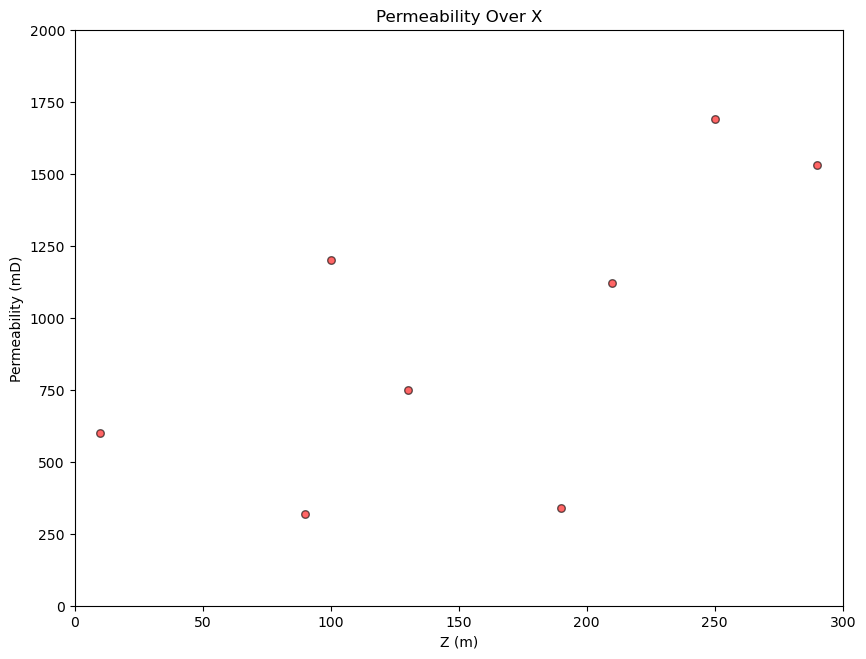

In [18]:
plt.subplot(111)
plt.scatter(df['z'].values,df['perm'].values, s=30, alpha = 0.6, edgecolors = "black", facecolors = 'red')
plt.xlabel('Z (m)')
plt.ylabel('Permeability (mD)')
plt.title('Permeability Over X')
plt.ylim(0.0,2000)
plt.xlim(0,300)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2); plt.show()

It seems pretty clear that permeability mean is not stationary over $z$, let's fit a variety of polygonal trends including, 1st, 3rd, 5th and 7th order polynomials (in order of increasing complexity).

We will plot the polynomial model fit with the (model training) data and the residual (training data - model) at sampled $z$ locations.

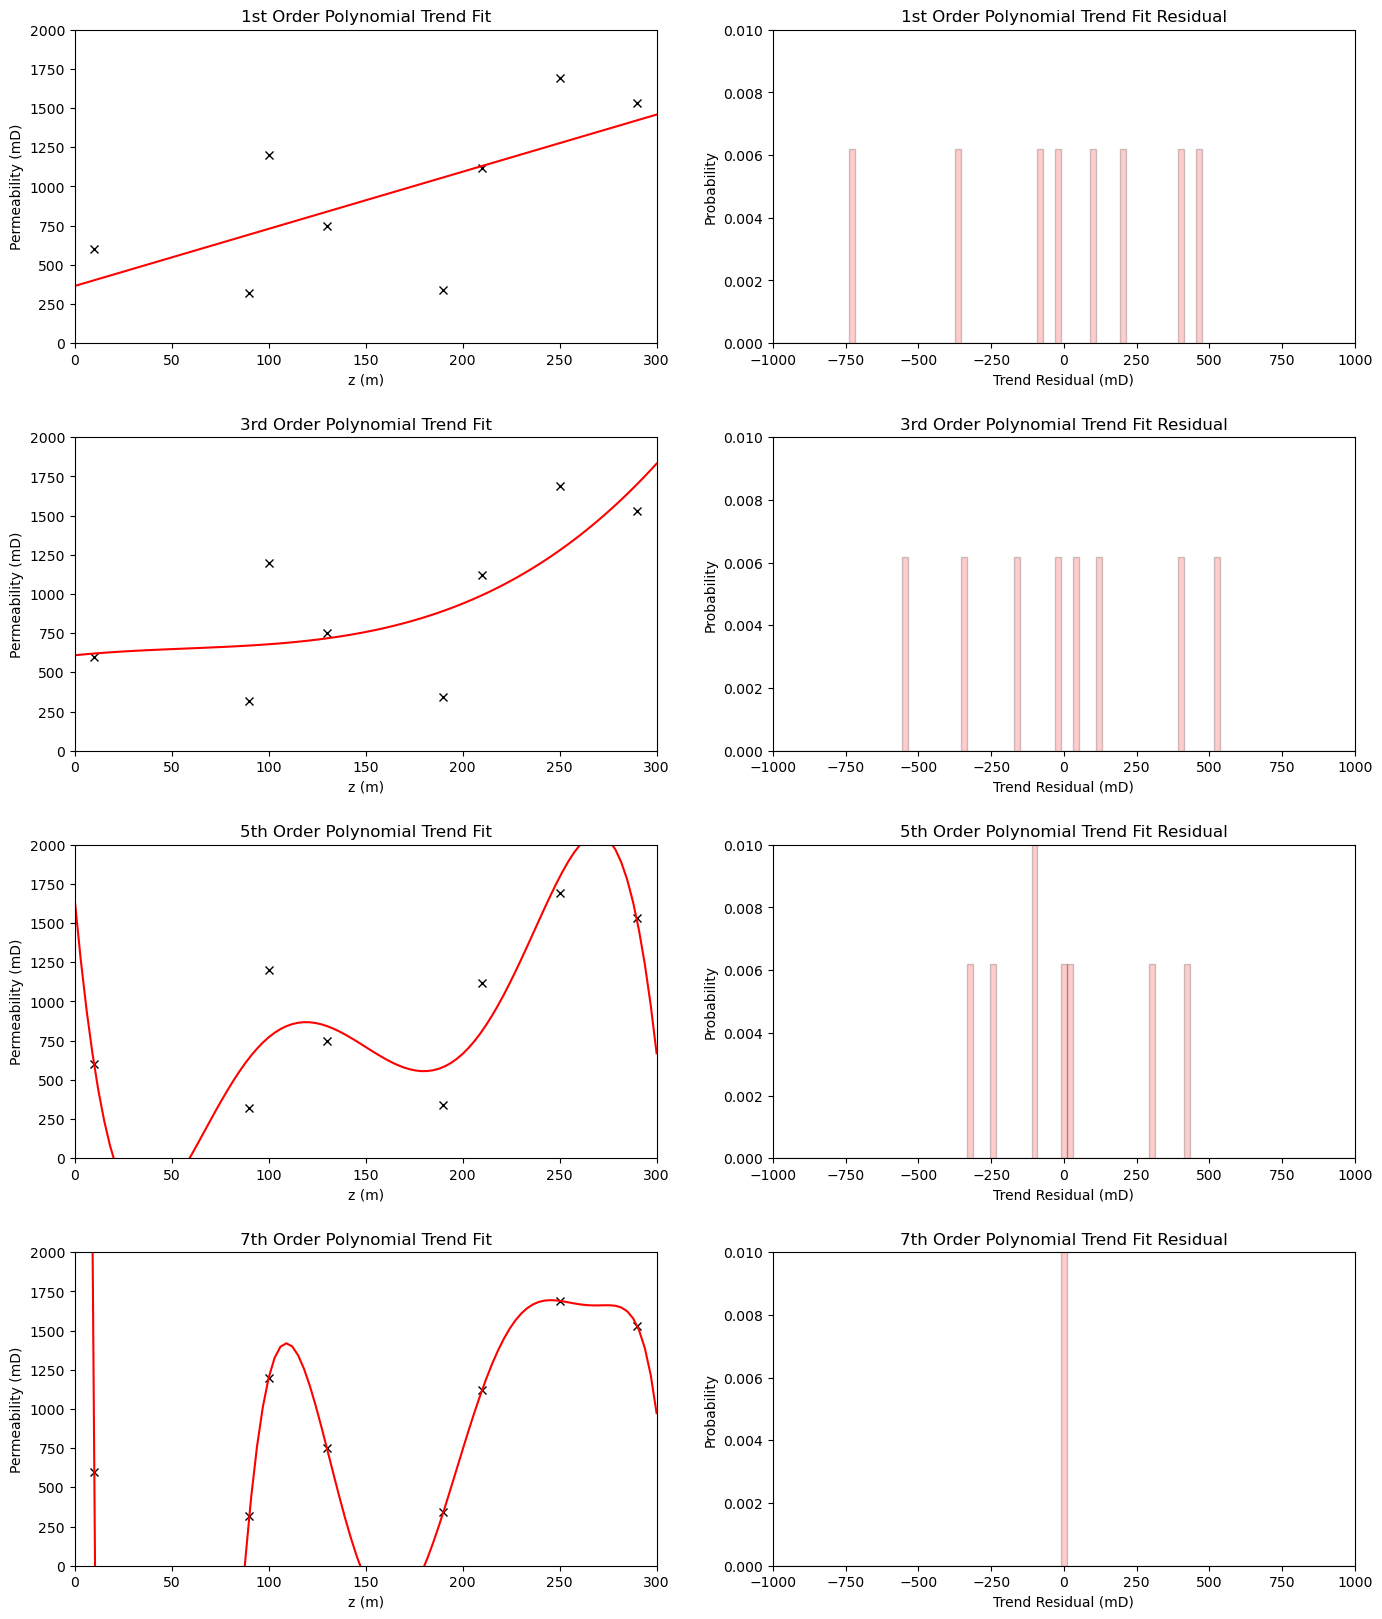

In [21]:
x = np.linspace(0, 300, 100)

p1 = np.polyfit(df['z'],df['perm'], deg=1, rcond=None, w=None, cov=False)
m1 = np.polyval(p1,x)

p3 = np.polyfit(df['z'],df['perm'], deg=3, rcond=None, w=None, cov=False)
m3 = np.polyval(p3,x)

p5 = np.polyfit(df['z'],df['perm'], deg=5, rcond=None, w=None, cov=False)
m5 = np.polyval(p5,x)

p7 = np.polyfit(df['z'],df['perm'], deg=7, rcond=None, w=None, cov=False)
m7 = np.polyval(p7,x)

plt.subplot(421)
plt.plot(df['z'],df['perm'], 'x', c='black')
plt.plot(x, m1, c='red')
plt.xlim([0,300]); plt.ylim([0,2000])
plt.xlabel('z (m)'); plt.ylabel('Permeability (mD)'); plt.title('1st Order Polynomial Trend Fit')

plt.subplot(422)
r1 = df['perm'].values - np.polyval(p1,df['z'].values)
plt.hist(r1, facecolor='red',bins=np.linspace(-1000,1000,100),alpha=0.2,density=True,edgecolor='black')
plt.xlim([-1000,1000]); plt.ylim([0,.01])
plt.xlabel('Trend Residual (mD)'); plt.ylabel('Probability'); plt.title('1st Order Polynomial Trend Fit Residual')

plt.subplot(423)
plt.plot(df['z'],df['perm'], 'x', c='black')
plt.plot(x, m3, c='red')
plt.xlim([0,300]); plt.ylim([0,2000])
plt.xlabel('z (m)'); plt.ylabel('Permeability (mD)'); plt.title('3rd Order Polynomial Trend Fit')

plt.subplot(424)
r3 = df['perm'].values - np.polyval(p3,df['z'].values)
plt.hist(r3, facecolor='red',bins=np.linspace(-1000,1000,100),alpha=0.2,density=True,edgecolor='black')
plt.xlim([-1000,1000]); plt.ylim([0,.01])
plt.xlabel('Trend Residual (mD)'); plt.ylabel('Probability'); plt.title('3rd Order Polynomial Trend Fit Residual')

plt.subplot(425)
plt.plot(df['z'],df['perm'], 'x', c='black')
plt.plot(x, m5, c='red')
plt.xlim([0,300]); plt.ylim([0,2000])
plt.xlabel('z (m)'); plt.ylabel('Permeability (mD)'); plt.title('5th Order Polynomial Trend Fit')

plt.subplot(426)
r5 = df['perm'].values - np.polyval(p5,df['z'].values)
plt.hist(r5, facecolor='red',bins=np.linspace(-1000,1000,100),alpha=0.2,density=True,edgecolor='black')
plt.xlim([-1000,1000]); plt.ylim([0,.01])
plt.xlabel('Trend Residual (mD)'); plt.ylabel('Probability'); plt.title('5th Order Polynomial Trend Fit Residual')

plt.subplot(427)
plt.plot(df['z'],df['perm'], 'x', c='black')
plt.plot(x, m7, c='red')
plt.xlim([0,300]); plt.ylim([0,2000])
plt.xlabel('z (m)'); plt.ylabel('Permeability (mD)'); plt.title('7th Order Polynomial Trend Fit')

plt.subplot(428)
r7 = df['perm'].values - np.polyval(p7,df['z'].values)
plt.hist(r7, facecolor='red',bins=np.linspace(-1000,1000,100),alpha=0.2,density=True,edgecolor='black')
plt.xlim([-1000,1000]); plt.ylim([0,.01])
plt.xlabel('Trend Residual (mD)'); plt.ylabel('Probability'); plt.title('7th Order Polynomial Trend Fit Residual')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.2, wspace=0.2, hspace=0.3)
plt.show()

#### Plot Extreme Under- and Overfit Models

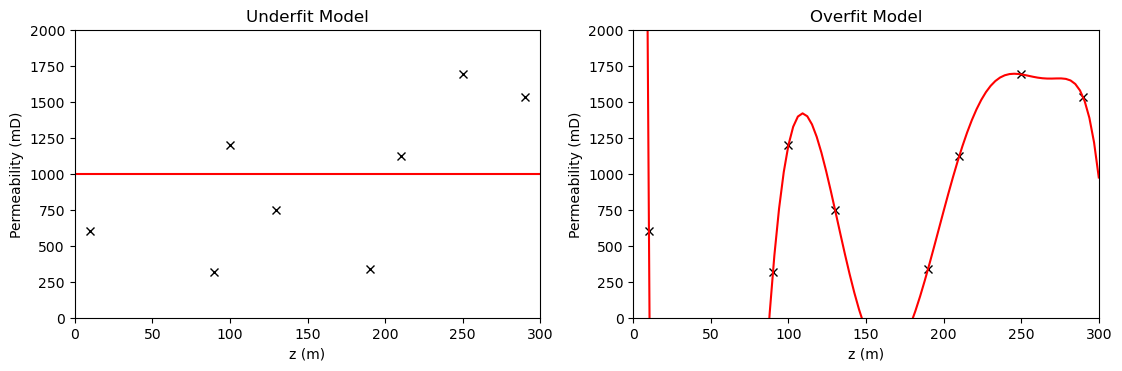

In [24]:
plt.subplot(121)
plt.plot(df['z'],df['perm'], 'x', c='black')
plt.plot(x, np.full((len(x)),1000), c='red')
plt.xlim([0,300]); plt.ylim([0,2000])
plt.xlabel('z (m)'); plt.ylabel('Permeability (mD)'); plt.title('Underfit Model')

plt.subplot(122)
plt.plot(df['z'],df['perm'], 'x', c='black')
plt.plot(x, m7, c='red')
plt.xlim([0,300]); plt.ylim([0,2000])
plt.xlabel('z (m)'); plt.ylabel('Permeability (mD)'); plt.title('Overfit Model')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.6, top=0.6, wspace=0.2, hspace=0.3)
plt.savefig('under_overfit.png',bbox_inches='tight',dpi=300)  # Save as a PNG file 
plt.show()

As the complexity of the model, the order of the polynomial, increases the flexibility to fit the data increases. With a 7th order polynomial we infact perfectly fit our 8 data and the residual is contant $=$ 0.  

**model bias** is due to the model's inability to fit the data. e.g. if the model is too simple vs. the complexity observed in the data then the model bias is high.  With out 7th order model, model bias is at a minimum as we are able to perfectly fit the data.

Going back to spatial modeling concepts, such as trend modeling, we can recognize that with our 7th order polynomial trend, we have a model that has described all variance in the data, all variance is assigned as known. This is very dangerous, indeed.  

What about the ability of this model to make predictions away from the observations used to build it (training data). I withheld some testing data. Let's put them into arrays and then a DataFrame like we did before and then plot them with the training data.

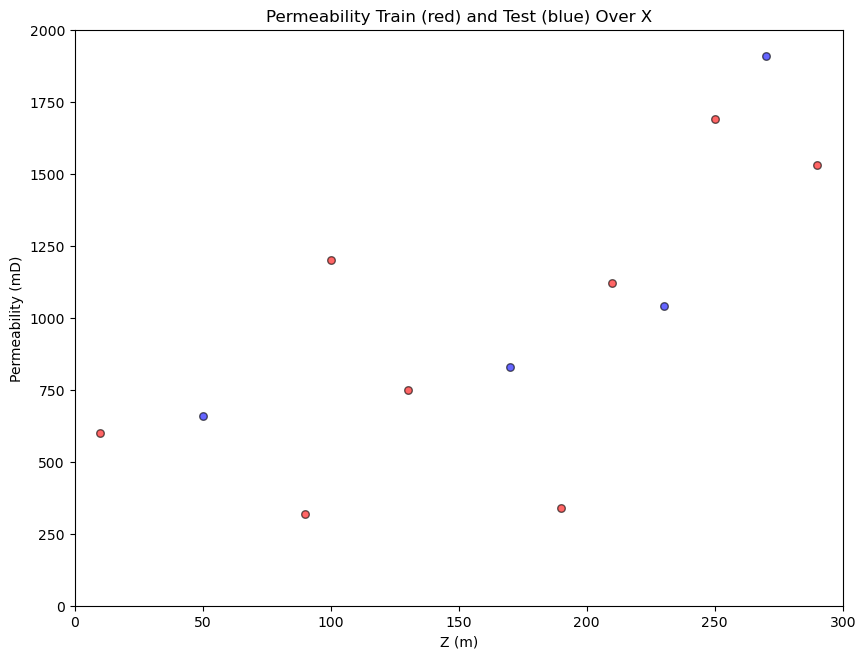

In [27]:
ztest = np.array([50,170,230,270])
permtest = np.array([660,830,1040,1910])
dftest = pd.DataFrame({'z':ztest,'perm':permtest})

plt.subplot(111)
plt.scatter(df['z'].values,df['perm'].values, s=30, alpha = 0.6, edgecolors = "black", facecolors = 'red')
plt.scatter(dftest['z'].values,dftest['perm'].values, s=30, alpha = 0.6, edgecolors = "black", facecolors = 'blue')
plt.xlabel('Z (m)')
plt.ylabel('Permeability (mD)')
plt.title('Permeability Train (red) and Test (blue) Over X')
plt.ylim(0.0,2000)
plt.xlim(0,300)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

The testing data looks fair. They are not unusual compared to the training data, that is they do not have different ranges of values, nor represent significant discontinuities or jumps in the data, also they are not spatially extrapolated. Now let's repeat the plots for our models over a range of complexities, but this time include the testing data for comparison and plot the residual distribution for the testing data (this is testing error).

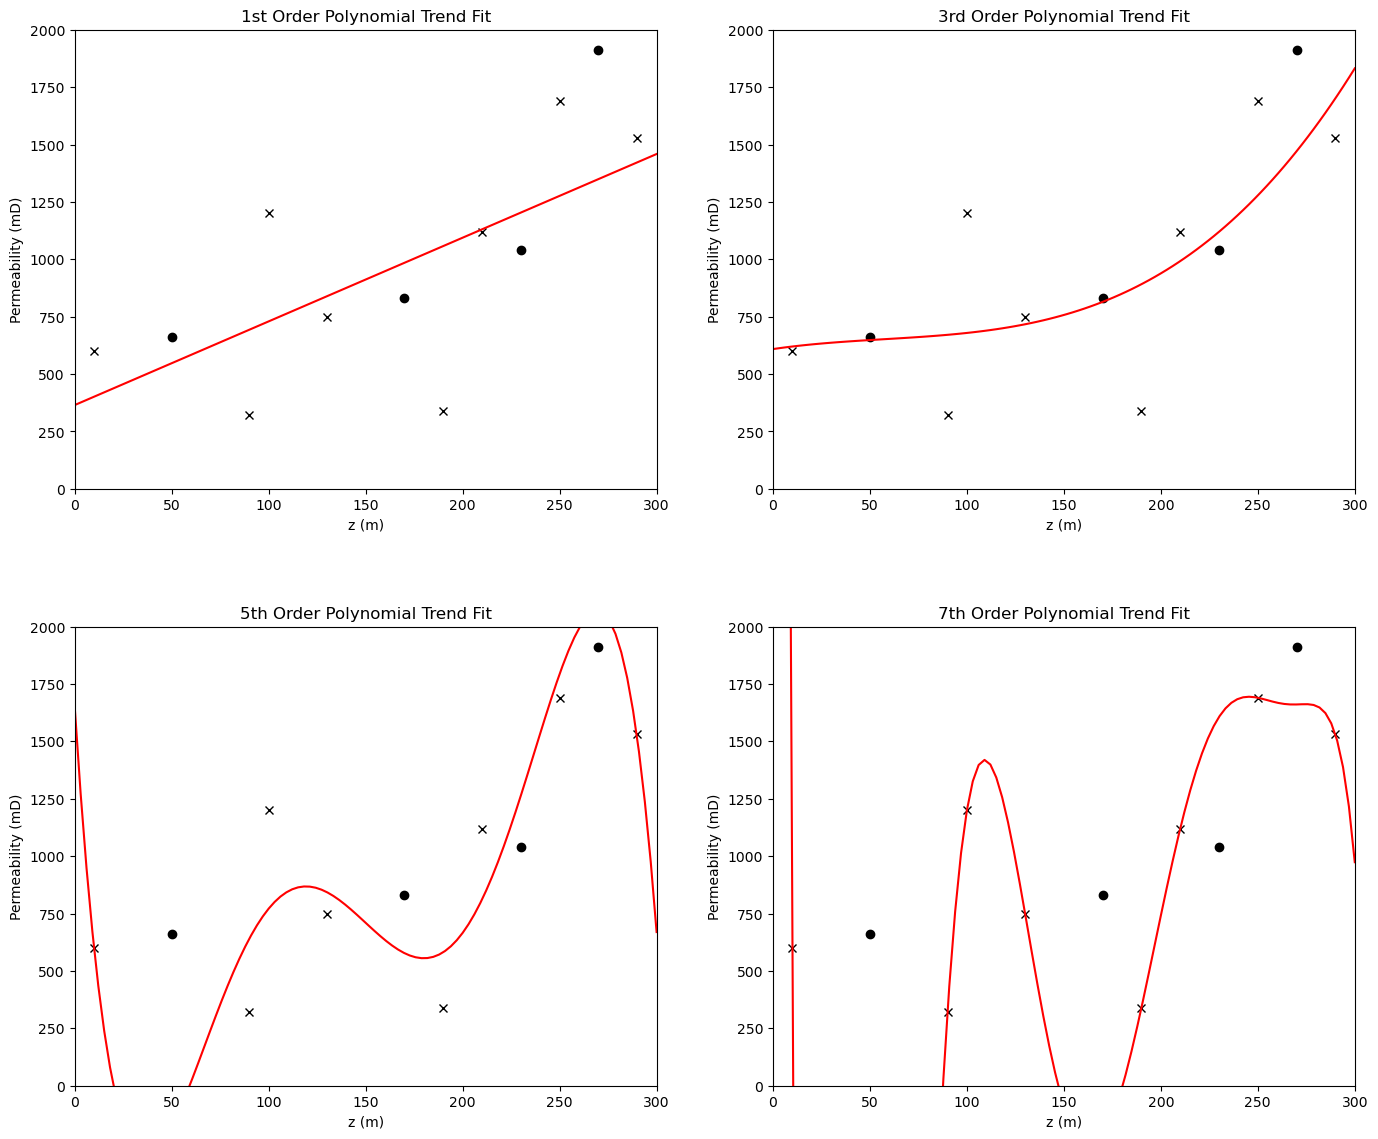

In [32]:
plt.subplot(221)
plt.plot(df['z'],df['perm'], 'x', c='black')
plt.plot(dftest['z'],dftest['perm'], 'o', c='black')
plt.plot(x, m1, c='red')
plt.xlim([0,300]); plt.ylim([0,2000])
plt.xlabel('z (m)'); plt.ylabel('Permeability (mD)'); plt.title('1st Order Polynomial Trend Fit')

plt.subplot(222)
plt.plot(df['z'],df['perm'], 'x', c='black')
plt.plot(dftest['z'],dftest['perm'], 'o', c='black')
plt.plot(x, m3, c='red')
plt.xlim([0,300]); plt.ylim([0,2000])
plt.xlabel('z (m)'); plt.ylabel('Permeability (mD)'); plt.title('3rd Order Polynomial Trend Fit')

plt.subplot(223)
plt.plot(df['z'],df['perm'], 'x', c='black')
plt.plot(dftest['z'],dftest['perm'], 'o', c='black')
plt.plot(x, m5, c='red')
plt.xlim([0,300]); plt.ylim([0,2000])
plt.xlabel('z (m)'); plt.ylabel('Permeability (mD)'); plt.title('5th Order Polynomial Trend Fit')

plt.subplot(224)
plt.plot(df['z'],df['perm'], 'x', c='black')
plt.plot(dftest['z'],dftest['perm'], 'o', c='black')
plt.plot(x, m7, c='red')
plt.xlim([0,300]); plt.ylim([0,2000])
plt.xlabel('z (m)'); plt.ylabel('Permeability (mD)'); plt.title('7th Order Polynomial Trend Fit')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.3); plt.show()

Now let's add the histograms of testing error to help compare the models.

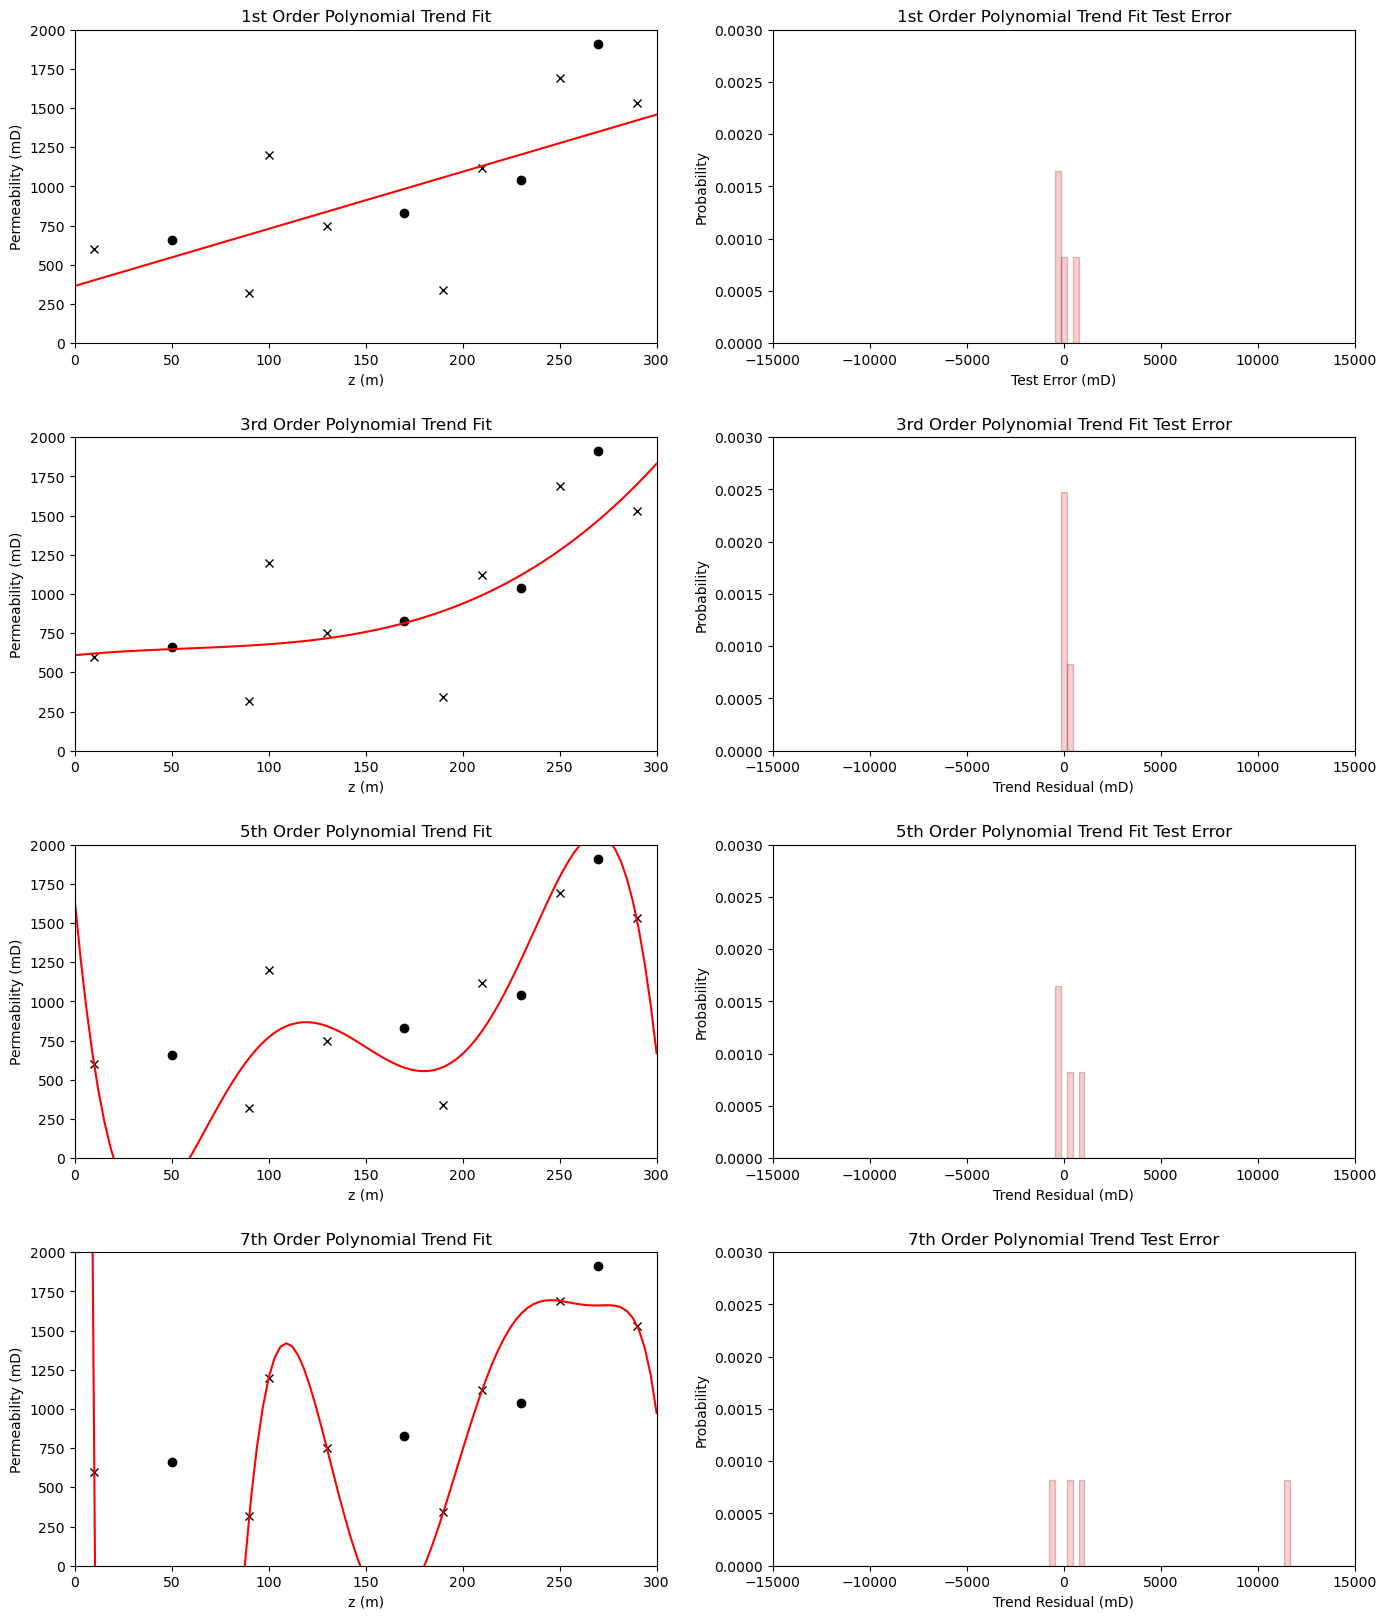

In [35]:
plt.subplot(421)
plt.plot(df['z'],df['perm'], 'x', c='black')
plt.plot(dftest['z'],dftest['perm'], 'o', c='black')
plt.plot(x, m1, c='red')
plt.xlim([0,300]); plt.ylim([0,2000])
plt.xlabel('z (m)'); plt.ylabel('Permeability (mD)'); plt.title('1st Order Polynomial Trend Fit')

plt.subplot(422)
r1test = dftest['perm'].values - np.polyval(p1,dftest['z'].values)
plt.hist(r1test, facecolor='red',bins=np.linspace(-15000,15000,100),alpha=0.2,density=True,edgecolor='black')
plt.xlim([-15000,15000]); plt.ylim([0,.003])
plt.xlabel('Test Error (mD)'); plt.ylabel('Probability'); plt.title('1st Order Polynomial Trend Fit Test Error')

plt.subplot(423)
plt.plot(df['z'],df['perm'], 'x', c='black')
plt.plot(dftest['z'],dftest['perm'], 'o', c='black')
plt.plot(x, m3, c='red')
plt.xlim([0,300]); plt.ylim([0,2000])
plt.xlabel('z (m)'); plt.ylabel('Permeability (mD)'); plt.title('3rd Order Polynomial Trend Fit')

plt.subplot(424)
r3test = dftest['perm'].values - np.polyval(p3,dftest['z'].values)
plt.hist(r3test, facecolor='red',bins=np.linspace(-15000,15000,100),alpha=0.2,density=True,edgecolor='black')
plt.xlim([-15000,15000]); plt.ylim([0,.003])
plt.xlabel('Trend Residual (mD)'); plt.ylabel('Probability'); plt.title('3rd Order Polynomial Trend Fit Test Error')

plt.subplot(425)
plt.plot(df['z'],df['perm'], 'x', c='black')
plt.plot(dftest['z'],dftest['perm'], 'o', c='black')
plt.plot(x, m5, c='red')
plt.xlim([0,300]); plt.ylim([0,2000])
plt.xlabel('z (m)'); plt.ylabel('Permeability (mD)'); plt.title('5th Order Polynomial Trend Fit')

plt.subplot(426)
r5test = dftest['perm'].values - np.polyval(p5,dftest['z'].values)
plt.hist(r5test, facecolor='red',bins=np.linspace(-15000,15000,100),alpha=0.2,density=True,edgecolor='black')
plt.xlim([-15000,15000]); plt.ylim([0,.003])
plt.xlabel('Trend Residual (mD)'); plt.ylabel('Probability'); plt.title('5th Order Polynomial Trend Fit Test Error')

plt.subplot(427)
plt.plot(df['z'],df['perm'], 'x', c='black')
plt.plot(dftest['z'],dftest['perm'], 'o', c='black')
plt.plot(x, m7, c='red')
plt.xlim([0,300]); plt.ylim([0,2000])
plt.xlabel('z (m)'); plt.ylabel('Permeability (mD)'); plt.title('7th Order Polynomial Trend Fit')

plt.subplot(428)
r7test = dftest['perm'].values - np.polyval(p7,dftest['z'].values)
plt.hist(r7test, facecolor='red',bins=np.linspace(-15000,15000,100),alpha=0.2,density=True,edgecolor='black')
plt.xlim([-15000,15000]); plt.ylim([0,.003])
plt.xlabel('Trend Residual (mD)'); plt.ylabel('Probability'); plt.title('7th Order Polynomial Trend Test Error')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.2, wspace=0.2, hspace=0.3)
plt.show()

See what happenned? As the complexity increased, our model becomes more inaccurate for the testing data. 

**model variance** is the sensitivity of the model to the exact data provided for training. Our 1st order model was not very sensitive to the training data, swapping training data with testing data would not have changed the model very much. Yet, with the 7th order model, making this swap would have dramatically changed the model.

Getting back to spatial modeling, with our complicated trend model, we have fit all the idiosyncracies in the data resulting in a very poor prediction model away from the data. This complicated model would not be a defendable trend model!

Can statistics help us further communicate that the complicated model is **not** a good model? You bet, we can plot the confidence interval in the trend models. This is an envelope of 95% uncertainty in the entire trend model given a limited number of noisy data (not to be confused with prediction interval for the next observation).    

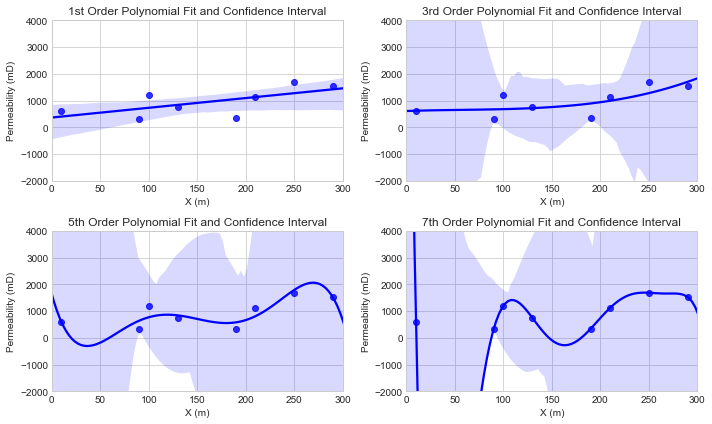

In [13]:
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
f,axes = plt.subplots(2,2,figsize=(10, 6))

lm1 = sns.regplot(df['z'],df['perm'], order=1,color ='blue',ax=axes[0, 0])
axes1 = lm1.axes; axes1.set_xlim(0,300); axes1.set_ylim(-2000,4000)
lm1.set(xlabel='X (m)', ylabel='Permeability (mD)', title='1st Order Polynomial Fit and Confidence Interval')

lm3 = sns.regplot(df['z'],df['perm'], order=3,color ='blue',ax=axes[0, 1])
axes3 = lm3.axes; axes3.set_xlim(0,300); axes3.set_ylim(-2000,4000)
lm3.set(xlabel='X (m)', ylabel='Permeability (mD)', title='3rd Order Polynomial Fit and Confidence Interval')

lm5 = sns.regplot(df['z'],df['perm'], order=5,color ='blue',ax=axes[1, 0])
axes5 = lm5.axes; axes5.set_xlim(0,300); axes5.set_ylim(-2000,4000)
lm5.set(xlabel='X (m)', ylabel='Permeability (mD)', title='5th Order Polynomial Fit and Confidence Interval')

lm7 = sns.regplot(df['z'],df['perm'], order=7,color ='blue',ax=axes[1, 1])
axes7 = lm7.axes; axes7.set_xlim(0,300); axes7.set_ylim(-2000,4000)
lm7.set(xlabel='X (m)', ylabel='Permeability (mD)', title='7th Order Polynomial Fit and Confidence Interval')


plt.tight_layout()

Due to the few data available, the confidence intervals expand repidly as the complexity increases. Statistics is telling us that we have no confidence in our model!  We do not have enough data to justify a complicated trend model.  

A quick caveat - if there is ancillary information to support a more complicated trend model then we should integrate it. For example, geological, engineering and geophyscial concepts may provide further support. Spatial trend modeling is not just about fitting the data!

#### Comments

This was a basic demonstration of overfitting in trend modeling. Much more could be done, such as randomizing the data and training observe model variance directly and use of other types of trend models (e.g. moving window averaging / convoluational models). 

I have other demonstrations on the basics of working with DataFrames, ndarrays and many other workflows availble at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy.

I hope this was helpful,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
